In [1]:
%load_ext autoreload
%autoreload 2

# CVAE example on MNIST

From https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb

100%|██████████| 937/937 [00:06<00:00, 142.10it/s]


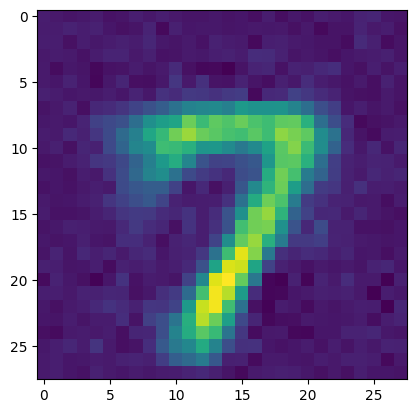

100%|██████████| 937/937 [00:03<00:00, 268.16it/s]


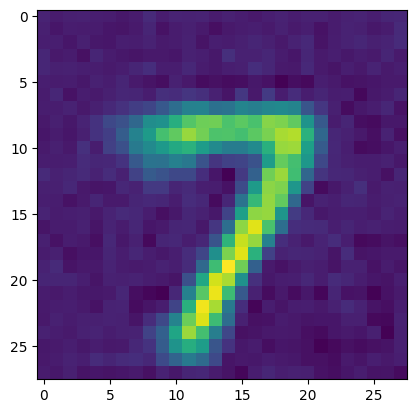

In [2]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import DataLoader
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from typing import List
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

data_path = './'

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

mnist_val = datasets.MNIST(data_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

train_loader = DataLoader(mnist_train, batch_size=64,
                          shuffle=True, pin_memory=True, drop_last=True)

val_loader = DataLoader(mnist_val, batch_size=1,
                        shuffle=False, pin_memory=True, drop_last=True)


class VAE_Encoder(hk.Module):
    def __init__(self, hidden_dims: List = None, name='VAE_Encoder'):
        super().__init__(name=name)
        if hidden_dims is None:
            hidden_dims = [64, 64]
        self.modules = []
        for h_dim in hidden_dims:
            self.modules.append((hk.Conv2D(output_channels=h_dim,
                                           kernel_shape=3, stride=2, padding=[1, 1]), hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.999)))
        self.fc_mu = hk.Linear(2)
        self.fc_var = hk.Linear(2)

    def __call__(self, x):
        for layer_i, bn_i in self.modules:
            x = layer_i(x)
            x = bn_i(x, is_training=True)
            x = jax.nn.leaky_relu(x)
        x = hk.Flatten()(x)
        mean = self.fc_mu(x)
        log_std = self.fc_var(x)
        return [mean, log_std]


class VAE_Decoder(hk.Module):
    def __init__(self, hidden_dims: List = None, name='VAE_Decoder'):
        super().__init__(name=name)
        if hidden_dims is None:
            self.hidden_dims = [64, 64]
        self.modules = []
        self.conv_dim = 7
        for h_dim in self.hidden_dims:
            self.modules.append((hk.Conv2DTranspose(output_channels=h_dim,
                                                    kernel_shape=3, stride=2), hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.999)))
        self.finally_Linear = hk.Linear(1)
        self.decoder_input = hk.Linear(self.conv_dim*self.conv_dim*self.hidden_dims[-1])

    def __call__(self, x):
        x = self.decoder_input(x)
        x = x.reshape(-1, self.conv_dim, self.conv_dim, self.hidden_dims[-1])
        for layer_i, bn_i in self.modules:
            x = layer_i(x)
            x = bn_i(x, is_training=True)
            x = jax.nn.leaky_relu(x)
        x = self.finally_Linear(x)
        # x = jax.nn.sigmoid(x)
        return x
    
    
class CVAE(hk.Module):
    def __init__(self, encoder, decoder, name='CVAE'):
        super().__init__(name=name)
        self.encoder = encoder
        self.decoder = decoder
    def __call__(self, batch):
        x, y = batch[0], batch[1]
        mu, log_var = self.encoder(x)
        z = reparameterize(mu, log_var)
        y = jax.nn.one_hot(y,10)
        z = jnp.concatenate([z, y], axis=1)
        z = self.decoder(z)
        return z, x, mu, log_var

def reparameterize(mean, stddev):
    z = mean + stddev * jax.random.normal(hk.next_rng_key(), mean.shape)
    return z

def vae():
    encoder = VAE_Encoder()
    decoder = VAE_Decoder()
    cvae = CVAE(encoder, decoder)
    def init(batch):
        x, y = batch[0], batch[1]
        mu, log_var = encoder(x)
        z = reparameterize(mu, log_var)
        y = jax.nn.one_hot(y,10)
        z = jnp.concatenate([z, y], axis=1)
        z = decoder(z)
        return [z, x, mu, log_var]
    return init, (cvae, encoder, decoder)

def vae_loss(params: hk.Params, state, batch, model):
    loss_input, state = model(params, state, rng_key, batch)
    recons = loss_input[0]
    ori_image = loss_input[1]
    mean = loss_input[2]
    var = loss_input[3]
    recons_loss = optax.l2_loss(recons, ori_image[:,:,:,:1])
    kld_loss = jnp.mean(-0.5 * jnp.sum(1 + var - mean**2 -
                        jnp.exp(var), axis=1), axis=0)
    loss = recons_loss + kld_loss* 0.00025
    return loss.mean()

vae_t = hk.multi_transform_with_state(vae)
rng_key = jax.random.PRNGKey(42)
dummy_x = jax.random.normal(rng_key, (8, 28, 28, 2))
dummy_y = jax.random.normal(rng_key, (8,))
params, state = vae_t.init(rng=rng_key, batch=[dummy_x,dummy_y])
cvae, encoder, decoder = vae_t.apply

optimizer = optax.adamw(learning_rate=0.001)
opt_state = optimizer.init(params)

@jax.jit
def step(params, opt_state, state, batch):
    loss_value, grads = jax.value_and_grad(vae_loss)(params, state, batch, cvae)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

for epoch in range(2):
    for x, y in tqdm(train_loader):
        x = jnp.array(x)
        y = jnp.array(y)
        y_1 = jnp.tile(y[:,None,None,None], (1, 1, 28, 28))
        x = jnp.concatenate((x,y_1), axis=1)
        x = jnp.transpose(x, (0, 2, 3, 1))
        params, opt_state, loss_value = step(params, opt_state, state,[x ,y])
    [x, y] = next(iter(val_loader))
    x = jnp.array(x)
    y = jnp.array([7])
    y_1 = jnp.tile(y[:,None,None,None], (1, 1, 28, 28))
    x = jnp.concatenate((x,y_1), axis=1)
    x = jnp.transpose(x, (0, 2, 3, 1))
    res,state = cvae(params, state,rng_key, [x,y])
    plt.imshow(res[0][0].reshape(28,28))
    plt.show()

In [3]:
n_samples = 6*6
c_fake = jax.random.randint(rng_key, (n_samples,), 0, 10)
c_fake = jax.nn.one_hot(c_fake, 10)
z_fake = jax.random.normal(rng_key, (n_samples, 2))
z_fake = jnp.concatenate([z_fake, c_fake], axis=1)
fake_imgs, _ = jax.vmap(decoder, in_axes=(None, None, None, 0))(params, state, rng_key, z_fake)

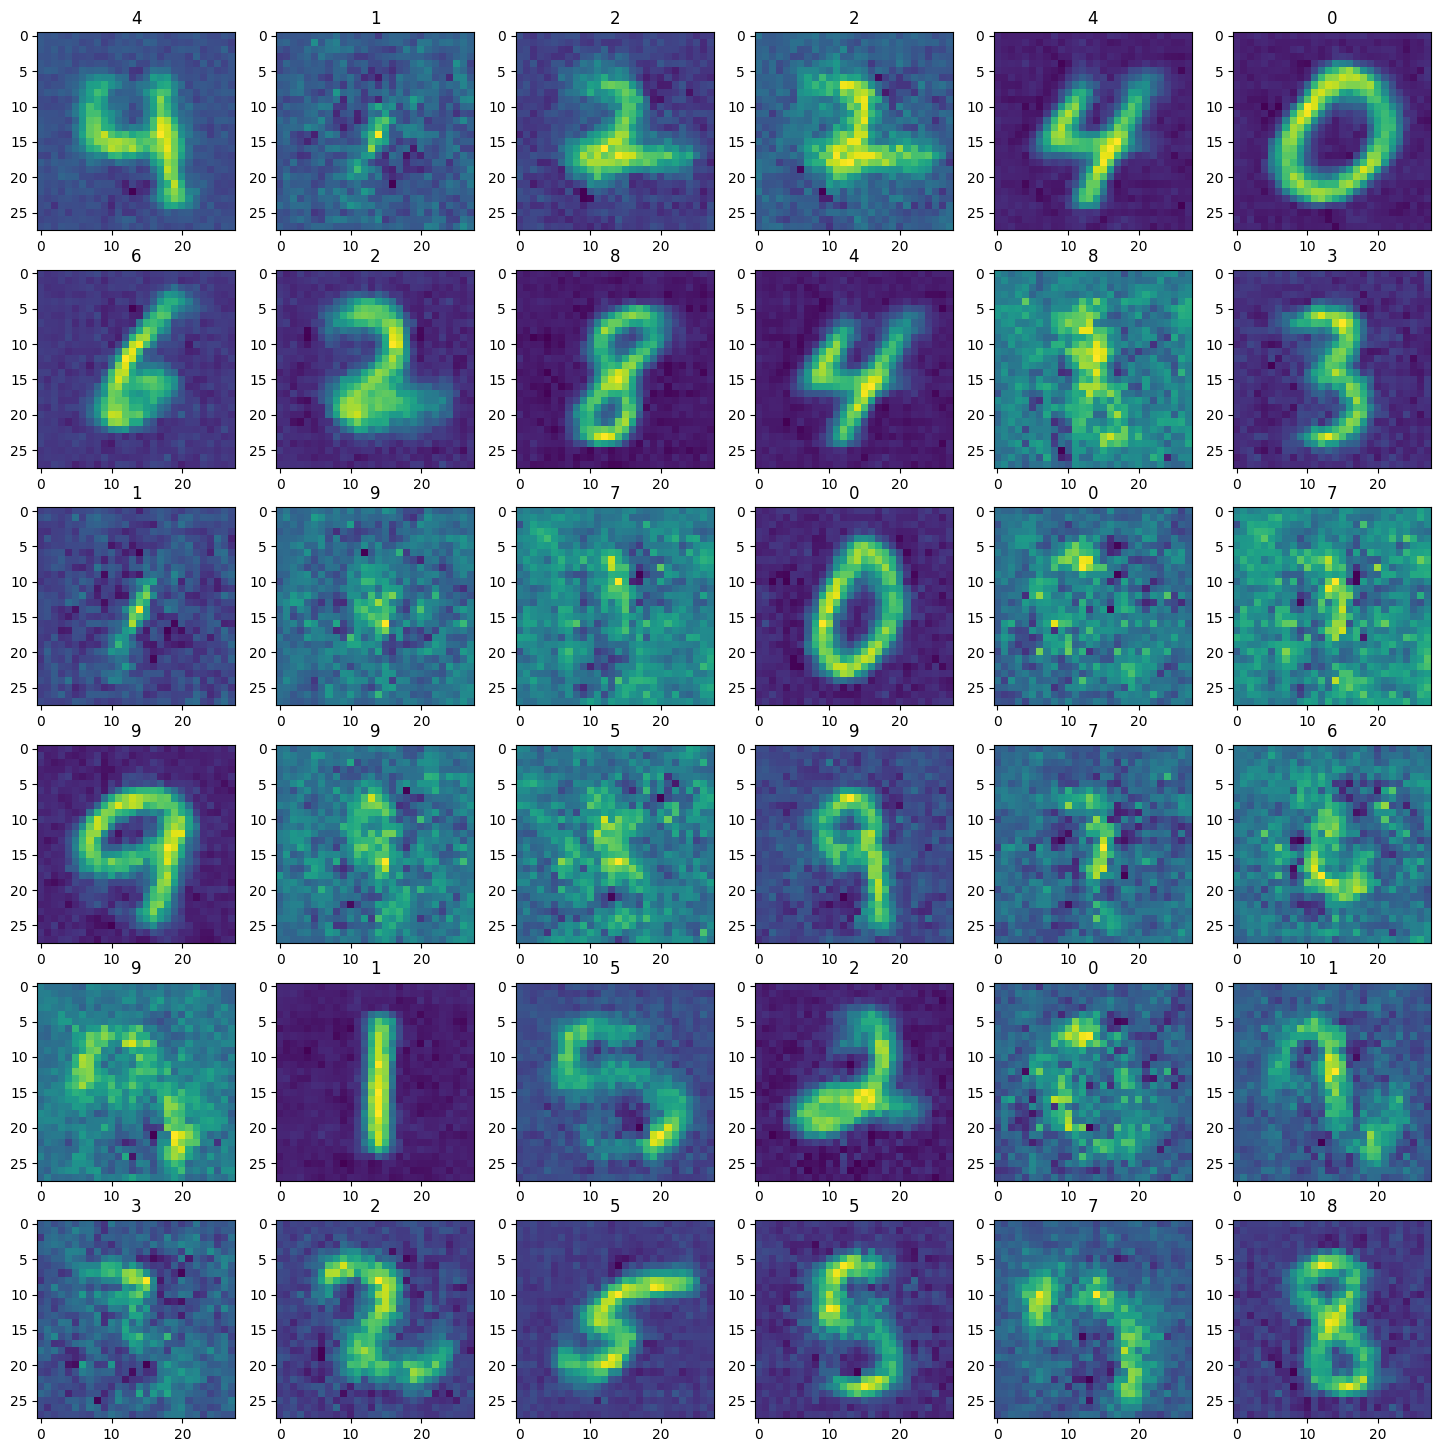

In [4]:
rows = int(np.ceil(np.sqrt(n_samples)))
cols = int(np.ceil(np.sqrt(n_samples)))
plt.figure(figsize=(3*cols, 3*rows))
for i in range(n_samples):
    plt.subplot(rows, cols, i+1)
    plt.imshow(fake_imgs[i].reshape(28,28))
    plt.title(np.where(c_fake[i])[0][0])